# Example 4. Make images

*[Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Oleg Ovcharenko](https://ovcharenkoo.com/), 2021. "Direct domain adaptation through mutual linear transformations"*

In [6]:
import os
import numpy as np

from torchvision import datasets
from torchvision import transforms

from components.data_loader import GetLoader
import components.shared as sd

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Accuracy curves

Load dict from ./out_ex1_dann/losses.pkl
Load dict from ./out_ex2_cnn/losses.pkl
Load dict from ./out_ex3_cnn_da/losses.pkl


(0.2, 1.05)

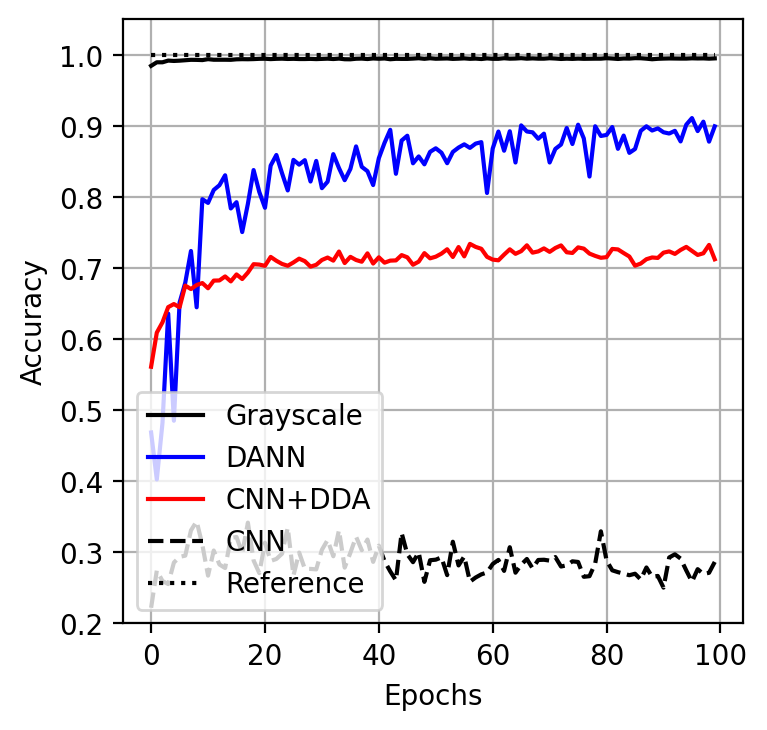

In [4]:
def plot_adopted_vs_direct(ad, dr, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.grid(True)
    ax.plot(ad['test']['acc_bw'], 'k', label='MNIST')
    ax.plot(ad['test']['acc_color'], 'r', label='MNIST-M\n(adopted)')
    ax.plot(dr['test']['acc_color'], 'k--', label='MNIST-M\n(direct)')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epochs')
    ax.legend(loc=1)
    ax.set_ylim([0.2, 1.05])

root_dann = './out_ex1_dann/'
root_cnn = './out_ex2_cnn/'
root_cnn_dda = './out_ex3_cnn_da/'

l_dann= sd.load_dict(os.path.join(root_dann,'losses.pkl'))
l_conv= sd.load_dict(os.path.join(root_cnn,'losses.pkl'))
l_da= sd.load_dict(os.path.join(root_cnn_dda,'losses.pkl'))

ax = None
if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
ax.grid(True)
ax.plot(l_conv['test']['acc_bw'], 'k', label='Grayscale')
ax.plot(l_dann['test']['acc_color'], 'b', label='DANN')
ax.plot(l_da['test']['acc_color'], 'r', label='CNN+DDA')
ax.plot(l_conv['test']['acc_color'], 'k--', label='CNN')
ax.plot(np.ones_like(l_da['test']['acc_color']), 'k:', label='Reference')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(loc=3)
ax.set_ylim([0.2, 1.05])

# Before / after images

In [5]:
# Paths to datasets
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)

# Where to save outputs
model_root = './out_ex3_cnn_da'
os.makedirs(model_root, exist_ok=True)

In [7]:
image_size = 28

# Transformations / augmentations
# The commented are true mean and std of the MNIST dataset.
mean_mnist = (0.1307, 0.1307, 0.1307)
std_mnist = (0.3081, 0.3081, 0.3081)
img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=mean_mnist, std=std_mnist),
])

mean_mnistm = (0.5, 0.5, 0.5)
std_mnistm = (0.5, 0.5, 0.5)
img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_mnistm, std=std_mnistm)
])

# Load MNIST dataset
dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

# Load MNIST-M dataset
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

In [8]:
from ipynb.fs.defs.ex3_cnn_da import (get_global_acorr_for_loader, 
                                      get_global_xcorr_for_loader,
                                     DDALoaderTrain,
                                     DDALoaderTest)

In [9]:
def route_to(fname):
    """ Shortcut for routing to the save folder """
    return os.path.join(model_root, fname)

# Compute global acorr if not in the folder, load otherwise
if not 'gacorr_dst_tr.npy' in os.listdir(model_root):
    print('Save global acorr')
    gacorr_dst_tr = get_global_acorr_for_loader(dataset_target)
    gacorr_src_tr = get_global_acorr_for_loader(dataset_source)
    np.save(route_to('gacorr_dst_tr.npy'), gacorr_dst_tr)
    np.save(route_to('gacorr_src_tr.npy'), gacorr_src_tr)
else:
    print('Load global acorr')
    gacorr_dst_tr = np.load(route_to('gacorr_dst_tr.npy'))
    gacorr_src_tr = np.load(route_to('gacorr_src_tr.npy'))

Load global acorr


In [10]:
# Window size
crop_size = 1
print(f'Use the crop size for xcorr = {crop_size}')

Use the crop size for xcorr = 1


In [11]:
# Compute global xcorr if not in the folder, load otherwise
if not 'gxcorr_dst_tr.npy' in os.listdir(model_root):
# if True:
    print('Save global xcorr')
    gxcorr_dst_tr = get_global_xcorr_for_loader(dataset_target, crop_size)
    gxcorr_src_tr = get_global_xcorr_for_loader(dataset_source, crop_size)
    np.save(route_to('gxcorr_dst_tr.npy'), gxcorr_dst_tr)
    np.save(route_to('gxcorr_src_tr.npy'), gxcorr_src_tr)
else:
    print('Load global xcorr')
    gxcorr_dst_tr = np.load(route_to('gxcorr_dst_tr.npy'))
    gxcorr_src_tr = np.load(route_to('gxcorr_src_tr.npy'))

Load global xcorr


In [12]:
# dataset_source = DDALoaderTrain(dataset_source, gacorr_dst_tr)
# dataset_target = DDALoaderTrain(dataset_target, gacorr_src_tr)

loader_src_tr = dataset_source
loader_dst_tr = dataset_target

In [13]:
def denorm(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    mean = np.expand_dims(np.expand_dims(mean, -1), -1)
    std = np.expand_dims(np.expand_dims(std, -1), -1)
    return ((img * std) + mean)

def plot_rgb(img, title='', ax=None):
    img = np.swapaxes(denorm(img), 0, -1)
    img = np.flipud(np.rot90(img))
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(img); ax.set_title(title); ax.axis('off')
    
def plot_rgb_bw(img, title='', ax=None):
    img = np.swapaxes(denorm(img, mean_mnist, std_mnist), 0, -1)
    img = np.flipud(np.rot90(img))
    if ax is None:
        fig, ax = plt.subplots(1, 1)
#     print(img.min(), img.max())
    ax.imshow(np.round(img, 2)); ax.set_title(title); ax.axis('off')

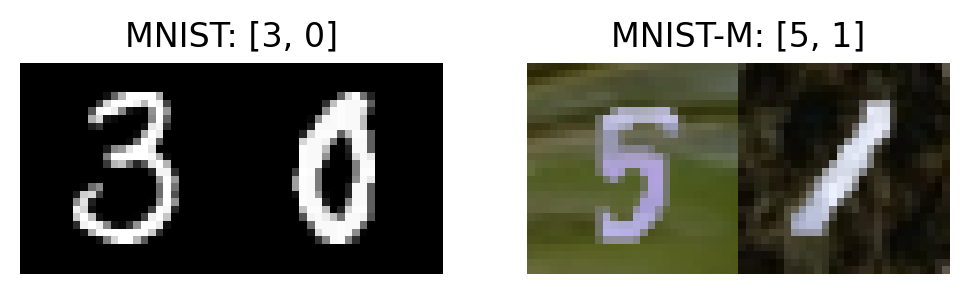

In [18]:
def get_n_from_loader(loader, n):
    imgs = []
    labels = []
    indices = np.random.randint(0, len(loader), n)
    for i in indices:
        di, dt = loader.__getitem__(i)
        di = di.cpu().numpy()
        imgs.append(di)
        labels.append(dt)
    return imgs, labels

fig, ax = plt.subplots(1,2)
imgs_src_tr, labels = get_n_from_loader(loader_src_tr, 2)
plot_rgb_bw(np.concatenate(imgs_src_tr, -1), f'MNIST: {labels}', ax=ax[0])

imgs_dst_tr, labels = get_n_from_loader(loader_dst_tr, 2)
plot_rgb(np.concatenate(imgs_dst_tr, -1), f'MNIST-M: {labels}', ax=ax[1])

In [52]:
from numpy.fft import rfft2, irfft2, fftshift, ifftshift

def info(x):
    print(x.shape, x.min(), x.max())
    
    
def fit_01(x):
    x -= x.min()
    x /= x.max()
    return x

    
def make_imgs(ds, acorr, reff, return_data=False):
    dsf = fftshift(rfft2(ds, s=ds.shape[-2:], axes=(-2, -1)))
    
    xcorr = dsf * np.conjugate(reff)
    conv = xcorr * acorr

    ref = np.round(irfft2(ifftshift(reff), axes=(-2, -1)), 2)
    aci = np.round(fftshift(irfft2(ifftshift(acorr), axes=(-2, -1))), 2)
    xci = np.round(fftshift(irfft2(ifftshift(xcorr), axes=(-2, -1))), 2)
    cvi = np.round(fftshift(irfft2(ifftshift(conv), axes=(-2, -1))), 2)

    
    fig, ax = plt.subplots(2, 4)
    if (ds[0, ...] == ds[1, ...]).all():
        plot_rgb_bw(ds, title ='Source (S)', ax=ax[0, 0])
    else:
        plot_rgb(ds, title ='Source (S)', ax=ax[0, 0])
        
    plot_rgb(np.concatenate([fit_01(ds[i, ...]) for i in range(3)]), ax=ax[1, 0])
    plot_rgb(fit_01(xci), title ='xcorr(S,R)', ax=ax[0, 1])
    plot_rgb(np.concatenate([fit_01(xci[i, ...]) for i in range(3)]), ax=ax[1, 1])
    
    plot_rgb(fit_01(ref), title ='ref (R)', ax=ax[0, 2])
    plot_rgb(np.concatenate([fit_01(aci[i, ...]) for i in range(3)]), ax=ax[1, 2])
    plot_rgb(fit_01(cvi), title ='conv(xcorr, acorr)', ax=ax[0, 3])
    
    img_cat = np.concatenate([np.concatenate([fit_01(cvi[i, ...]), fit_01(-cvi[i, ...])], -1) for i in range(3)])
    plot_rgb(img_cat, ax=ax[1, 3])
    
    if return_data:
        return cvi


    
# # for dim_ref in [1, 3, 5, 7, 9, 12, 16, 20]:
# one_src_img = imgs_src_tr[0]
# one_src_img_dda = make_imgs(one_src_img, gacorr_dst_tr, gxcorr_src_tr, return_data=True)

# one_dst_img = imgs_dst_tr[0]
# one_dst_img_dda = make_imgs(one_dst_img, gacorr_src_tr, gxcorr_dst_tr, return_data=True)

In [53]:
# make_imgs(imgs_src_tr[0], gacorr_dst_tr, gxcorr_src_tr)
# make_imgs(imgs_dst_tr[0], gacorr_src_tr, gxcorr_dst_tr)

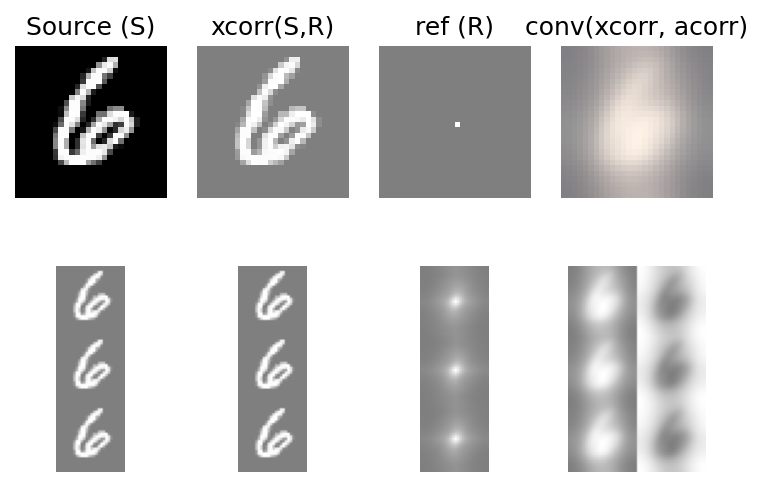

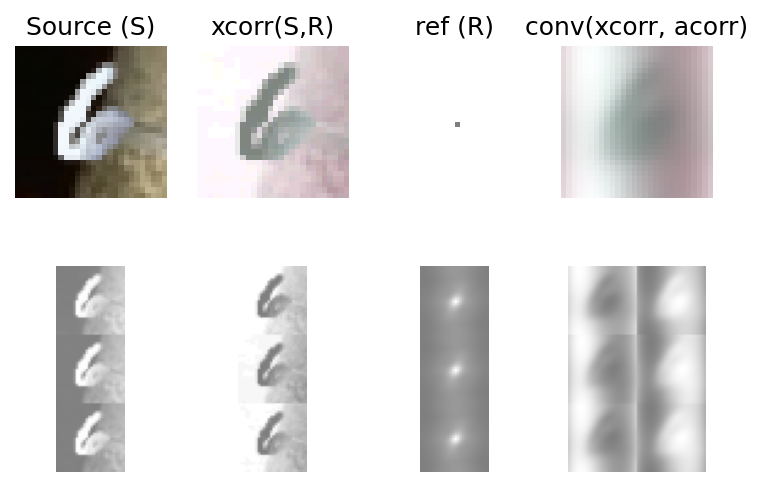

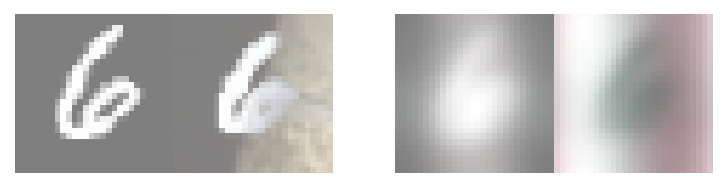

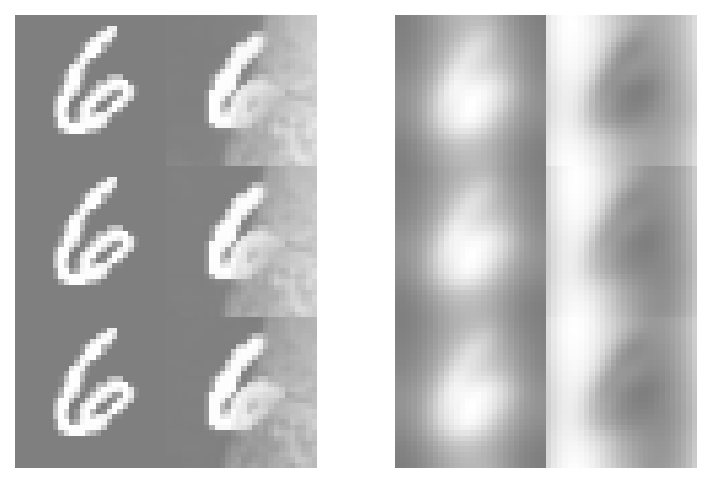

In [54]:
def get_img_by_label(loader, label):
    fetched_label = -1
    maxiter = 100
    this_iter = 0
    
    while fetched_label != label and this_iter < maxiter:
        img, fetched_label = loader.__getitem__(this_iter)
        this_iter += 1
    return img, fetched_label

want_label = 6
img_src_tr_want, this_label_src_tr = get_img_by_label(loader_src_tr, want_label)
img_dst_tr_want, this_label_dst_tr = get_img_by_label(loader_dst_tr, want_label)
img_src_tr_want_dda = make_imgs(img_src_tr_want, gacorr_dst_tr, gxcorr_src_tr, return_data=True)
img_dst_tr_want_dda = make_imgs(img_dst_tr_want, gacorr_src_tr, gxcorr_dst_tr, return_data=True)

fig, ax = plt.subplots(1, 2)
plot_rgb(np.concatenate([img_src_tr_want, img_dst_tr_want], -1), ax = ax[0])
plot_rgb(np.concatenate([img_src_tr_want_dda, img_dst_tr_want_dda], -1), ax = ax[1])

fig, ax = plt.subplots(1, 2)
plot_rgb(np.concatenate([np.concatenate([fit_01(img_src_tr_want[i, ...]) for i in range(3)]),
                        np.concatenate([fit_01(img_dst_tr_want[i, ...]) for i in range(3)])], -1),
                        ax = ax[0])
plot_rgb(np.concatenate([np.concatenate([fit_01(img_src_tr_want_dda[i, ...]) for i in range(3)]),
                        np.concatenate([fit_01(img_dst_tr_want_dda[i, ...]) for i in range(3)])], -1),
                        ax = ax[1])


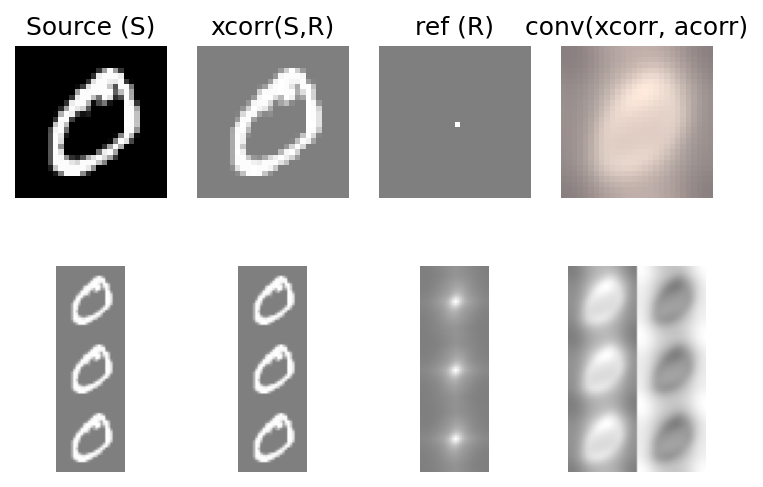

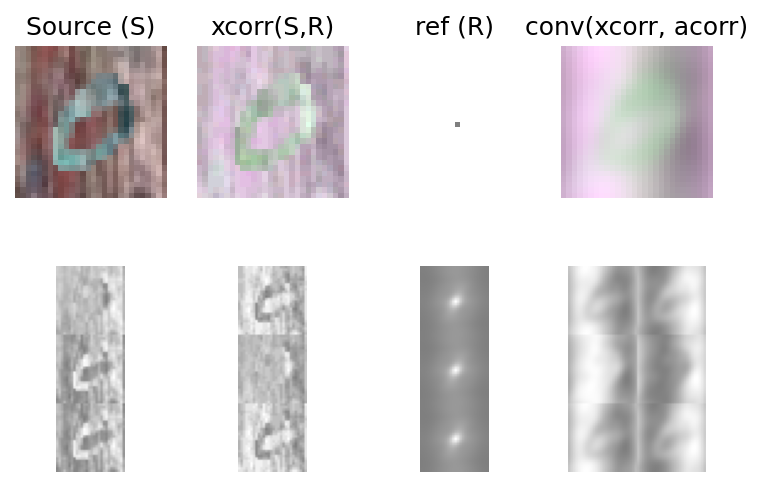

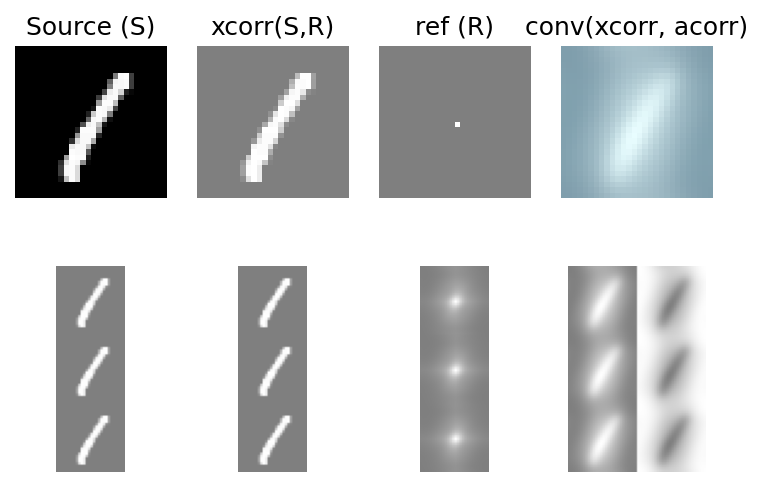

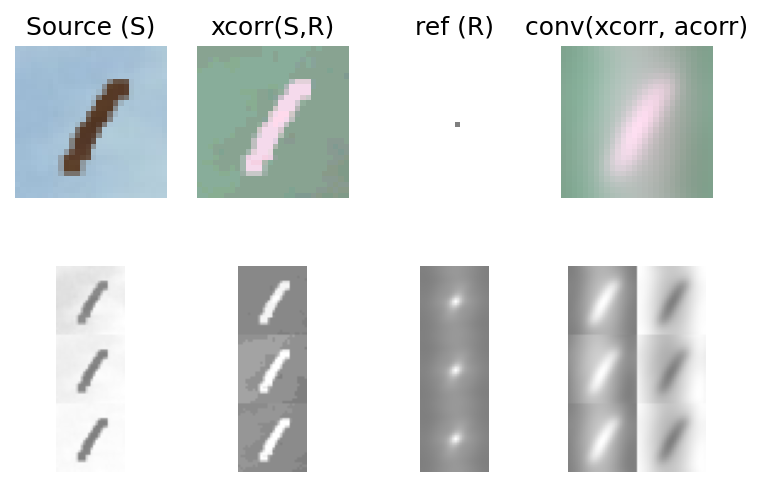

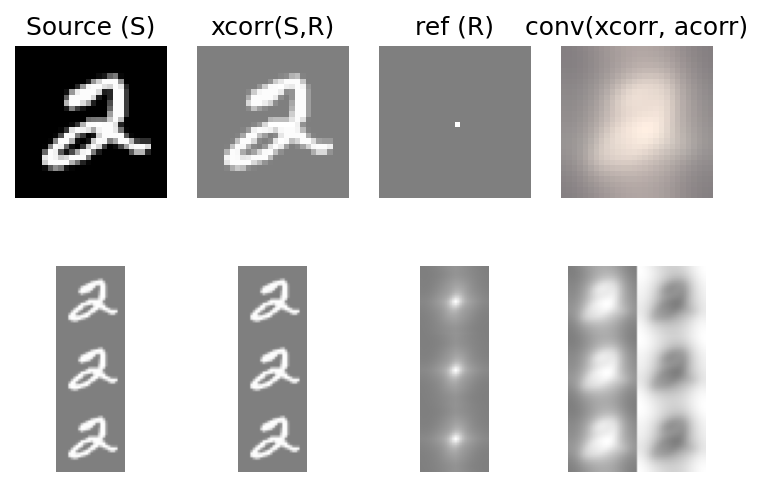

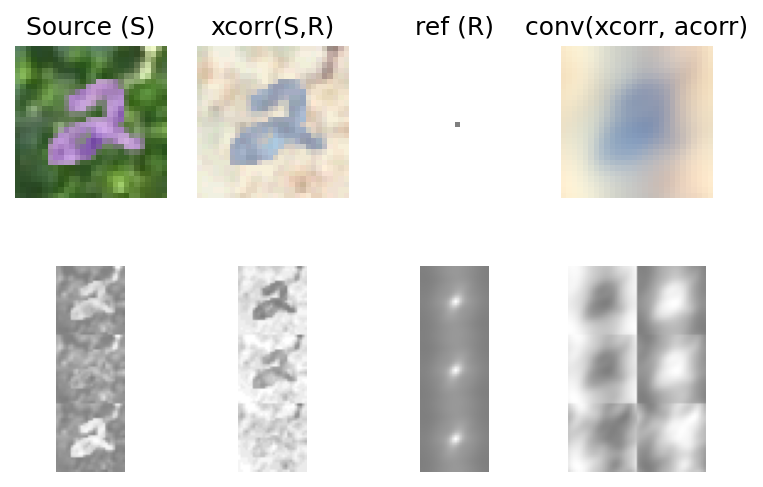

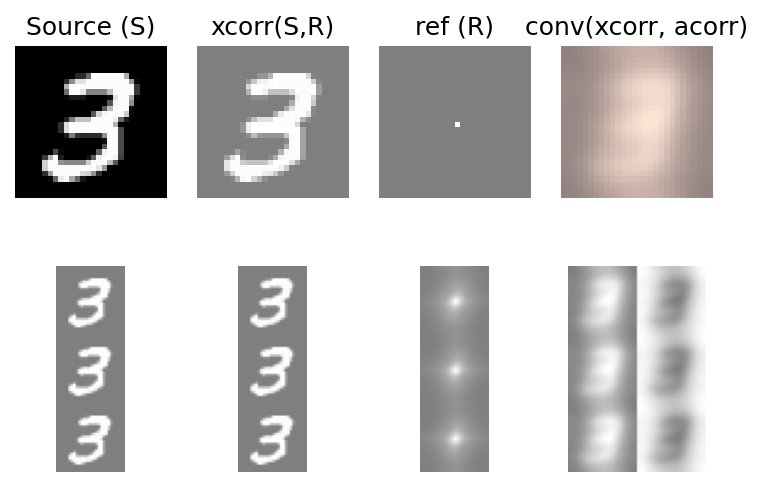

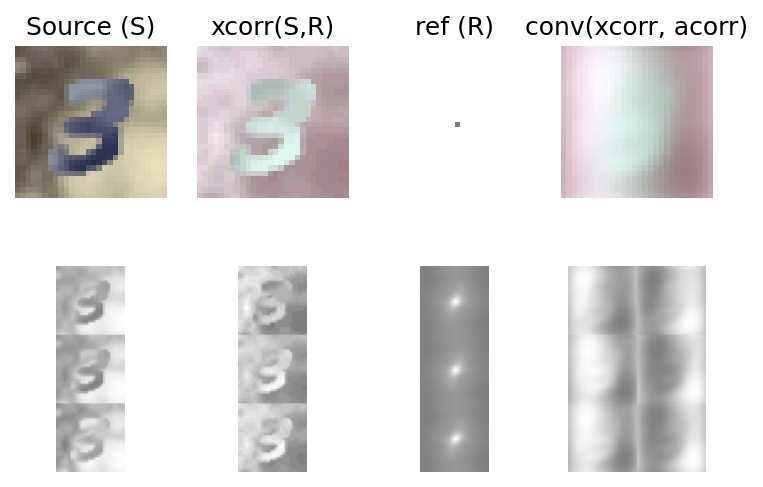

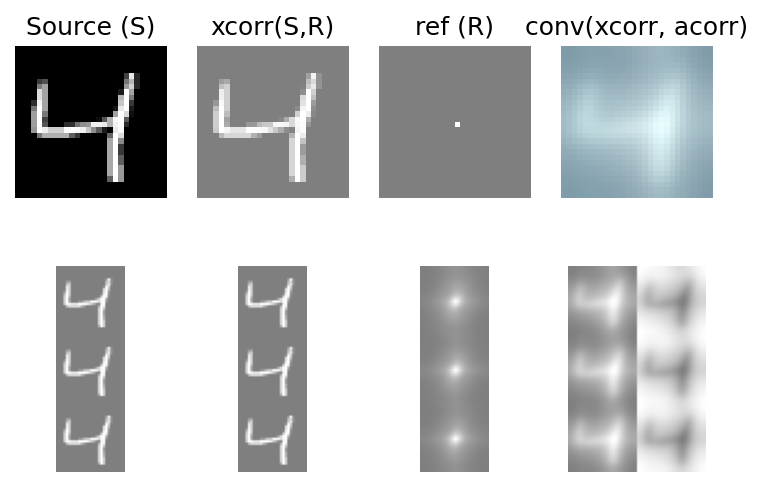

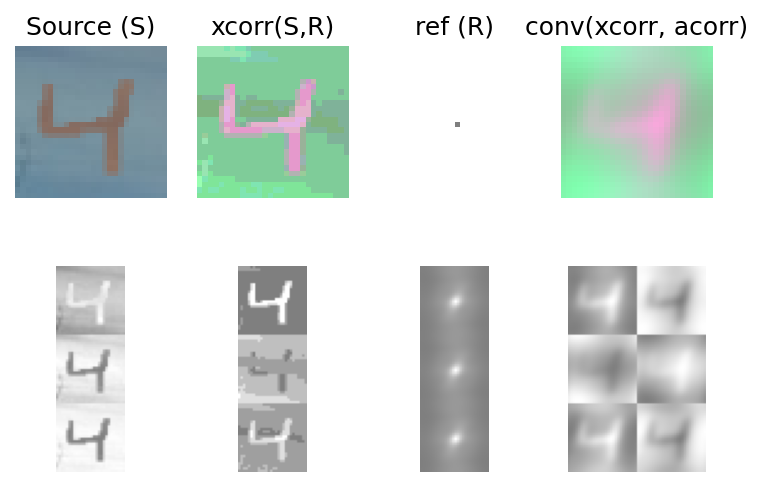

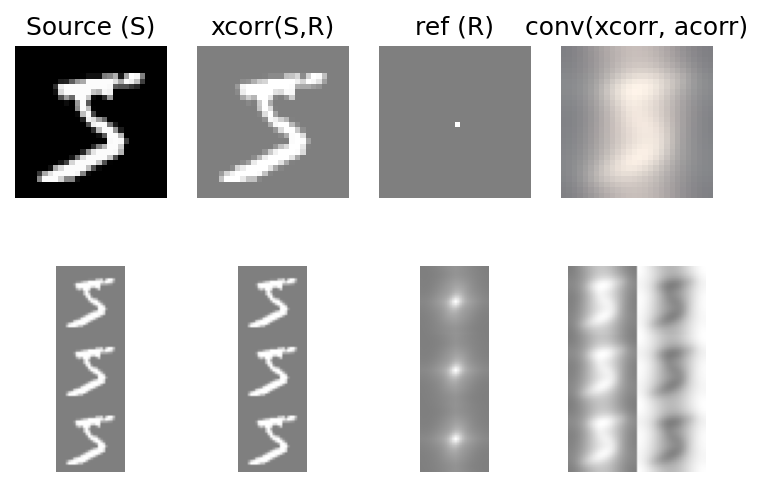

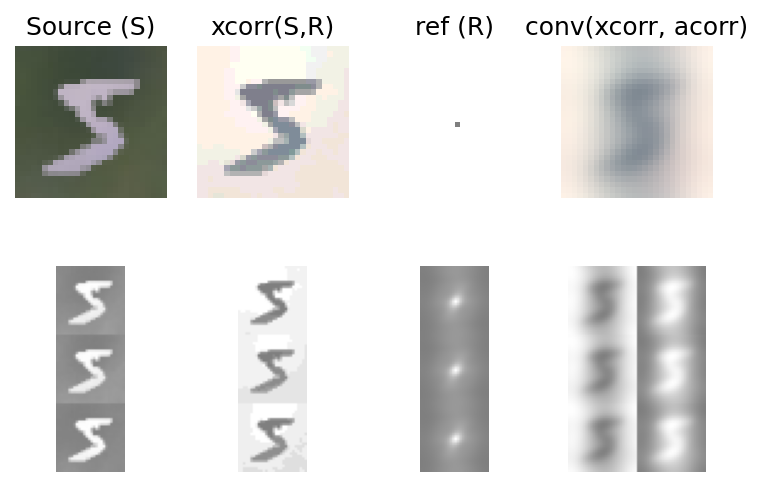

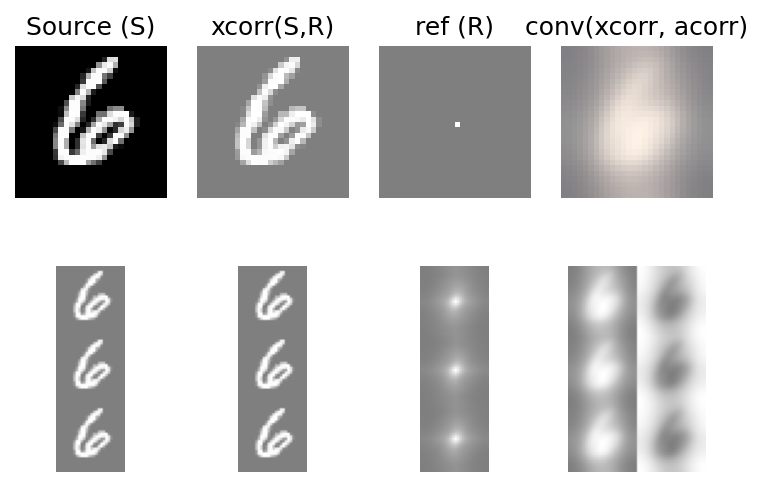

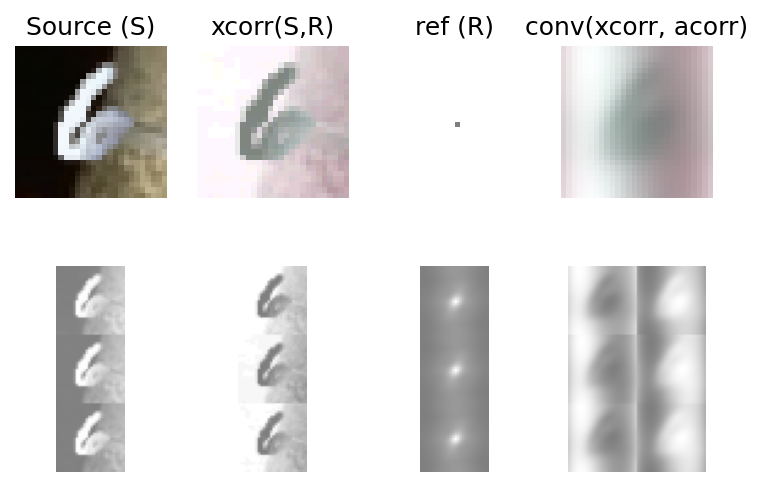

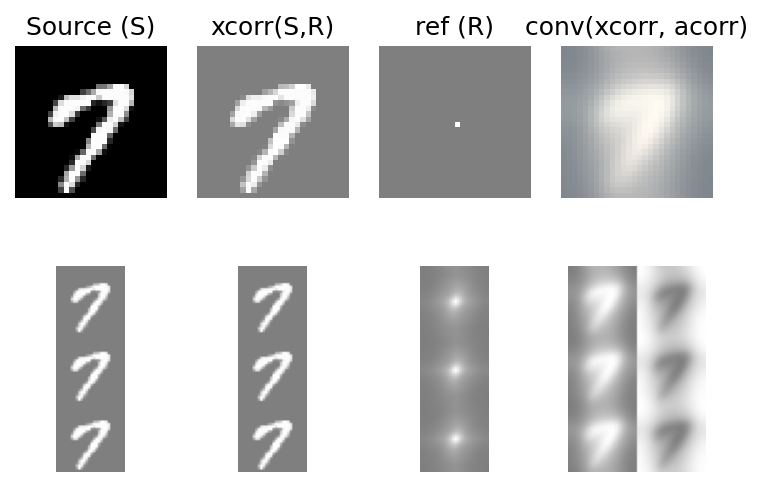

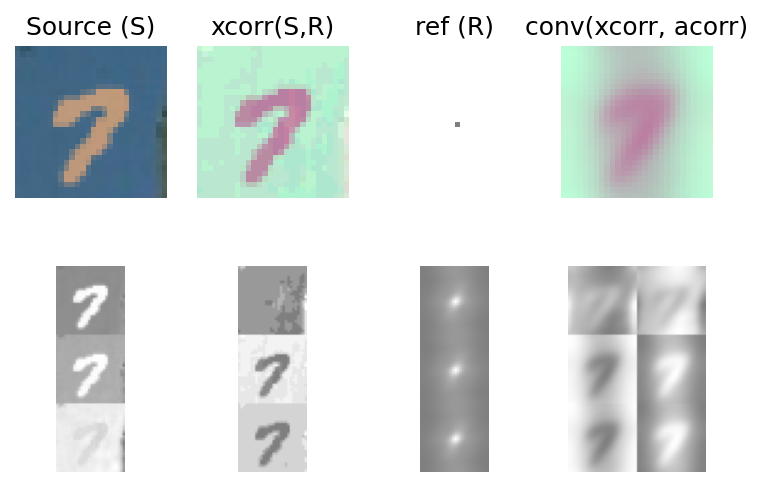

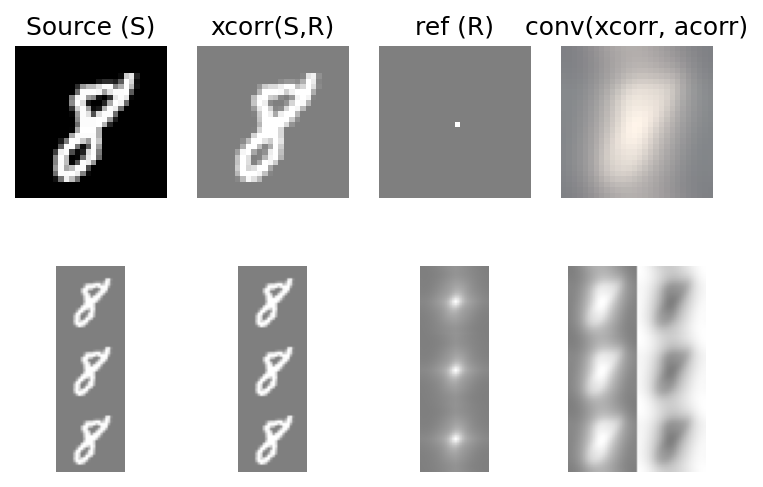

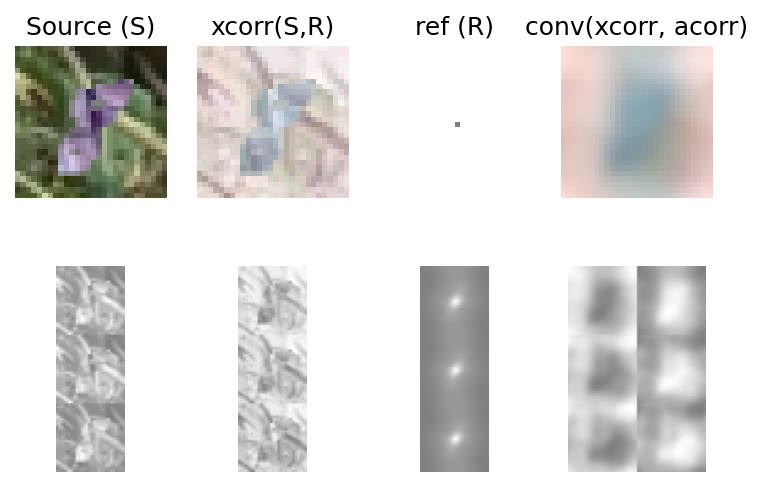

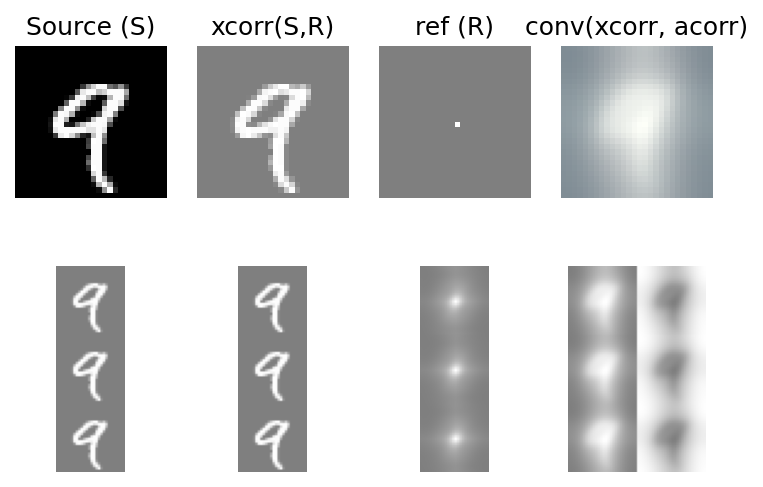

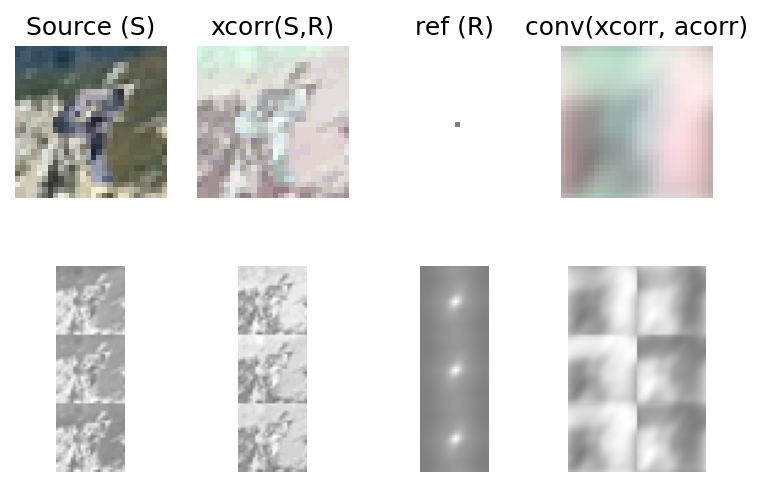

In [56]:
mpl.rcParams['figure.dpi']= 150
for want_label in [i for i in range(10)]:
    img_src_tr_want, this_label_src_tr = get_img_by_label(loader_src_tr, want_label)
    img_dst_tr_want, this_label_dst_tr = get_img_by_label(loader_dst_tr, want_label)
    make_imgs(img_src_tr_want, gacorr_dst_tr, gxcorr_src_tr)
    make_imgs(img_dst_tr_want, gacorr_src_tr, gxcorr_dst_tr)

In [57]:
cloader_src_tr = DDALoaderTrain(loader_src_tr, gacorr_dst_tr)
cloader_dst_tr = DDALoaderTrain(loader_dst_tr, gacorr_src_tr)
# cloader_src_te = DDALoaderTrain(loader_src_te, gacorr_dst_te)
# cloader_dst_te = DDALoaderTrain(loader_dst_te, gacorr_src_te)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 28, 28]) tensor(-0.4242) tensor(2.8215)
torch.Size([3, 28, 28]) tensor(-1.) tensor(0.9922)
(3, 28, 28) -1.0 1.0
(3, 28, 28) -1.0 1.0


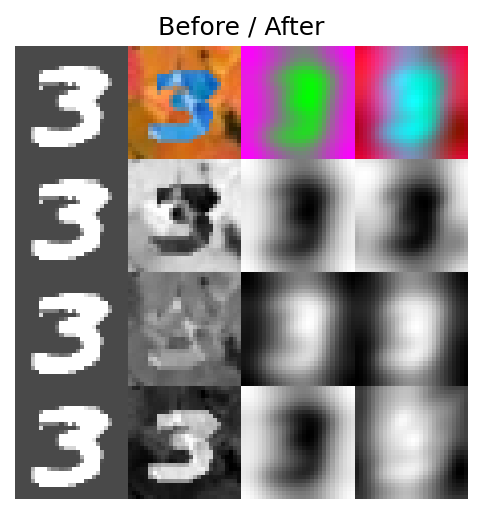

In [93]:
def plot_table(datas, title='', ax=None):
    columns = []
    for d in datas:
        top_img = d
        bot_img = np.repeat(np.concatenate([d[i, ...] for i in range(3)])[np.newaxis, ...], 3, 0)
        one_col = np.concatenate([top_img, bot_img], 1)
        columns.append(one_col)
    table = np.concatenate(columns, -1)
    table = np.swapaxes(table, 0, -1)
    table += 1
    table /= 2
    if not ax:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(np.flip(np.rot90(table), 0))
    ax.set_title(title)
    ax.axis('off')

    
datas = []
labels = []
for loader in [loader_src_tr, loader_dst_tr, cloader_src_tr, cloader_dst_tr]:
    data, label = loader.__getitem__(27)
    print(data.shape, data.min(), data.max())
    datas.append(data)
    labels.append(label)
plot_table(datas, title='Before / After')

[7, 9, 7, 3, 7]
[9, 3, 1, 0, 8]


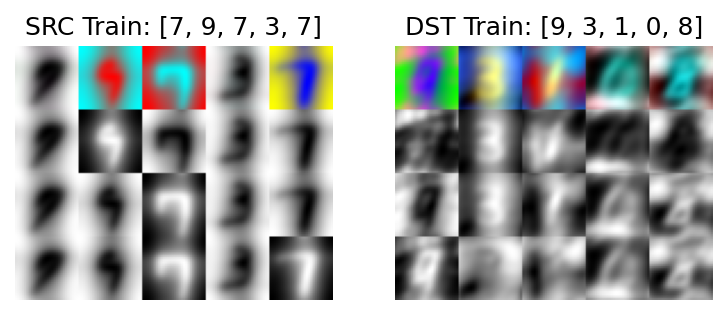

In [59]:
def plot_table_loader(loader, n=5, **kwargs):
    datas = []
    labels = []
    for i in range(n):
        data, label = loader.__getitem__(np.random.randint(len(loader)))
#         print(data.shape, data.min(), data.max())
        datas.append(data)
        labels.append(label)
    print(labels)
    kwargs['title'] += str(labels)
    plot_table(datas, **kwargs)

fig, ax = plt.subplots(1, 2)
plot_table_loader(cloader_src_tr, title=f'SRC Train: ', ax=ax[0])
plot_table_loader(cloader_dst_tr, title='DST Train: ', ax=ax[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8, 9, 0, 3, 3]
[0, 3, 4, 2, 3]


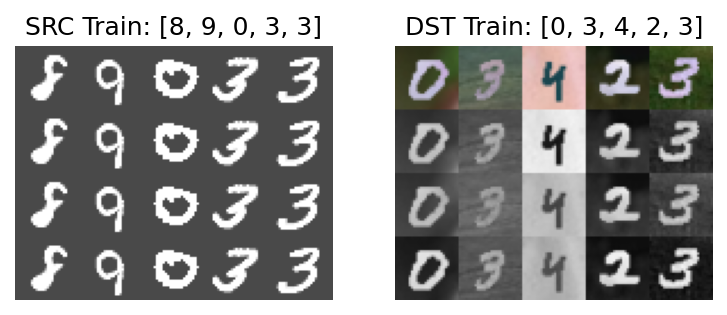

In [60]:
fig, ax = plt.subplots(1, 2)
plot_table_loader(loader_src_tr, title=f'SRC Train: ', ax=ax[0])
plot_table_loader(loader_dst_tr, title='DST Train: ', ax=ax[1])

# T-SNE

In [21]:
def get_n_from_loader(loader, indices):
    dats = []
    labels = []
    for index in indices:
        dat, label = loader.__getitem__(index)
        dats.append(dat.reshape(1, -1))
        labels.append(label)
    return np.concatenate(dats, 0), labels

def get_merged_dats_labels_for_two_loaders(l1, l2, indices):
    print(f'Get {len(indices)} indices from loader')
    nums_src_tr, labels_src_tr = get_n_from_loader(l1, indices)
    nums_dst_tr, labels_dst_tr = get_n_from_loader(l2, indices)
    nums_tr = np.concatenate([nums_dst_tr, nums_src_tr], 0)
    labels_tr = labels_dst_tr + labels_src_tr
    print(f'Dataset for T-SNE: {nums_tr.shape}\nLabels dst:\t{labels_dst_tr[:5]}...\nLabels src:\t{labels_src_tr[:5]}...')
    return nums_tr, labels_tr

## Training data

In [22]:
indices = [i for i in range(0, int(0.9 * len(cloader_src_tr)), 500)]
nums_tr, labels_tr = get_merged_dats_labels_for_two_loaders(cloader_src_tr, cloader_dst_tr, indices)

Get 108 indices from loader
Dataset for T-SNE: (216, 2352)
Labels dst:	[5, 3, 0, 9, 5]...
Labels src:	[5, 3, 0, 9, 5]...


In [23]:
nums_tr_orig, labels_tr_orig = get_merged_dats_labels_for_two_loaders(loader_src_tr, loader_dst_tr, indices)

Get 108 indices from loader
Dataset for T-SNE: (216, 2352)
Labels dst:	[5, 3, 0, 9, 5]...
Labels src:	[5, 3, 0, 9, 5]...


In [24]:
# %% time
from sklearn.manifold import TSNE

print('Start T-SNE in parallel...')
features_2d = TSNE(n_components=2, n_jobs=-1).fit_transform(nums_tr)
features_2d_orig = TSNE(n_components=2, n_jobs=-1).fit_transform(nums_tr_orig)
print(features_2d.shape, features_2d_orig.shape)

Start T-SNE in parallel...
(216, 2) (216, 2)


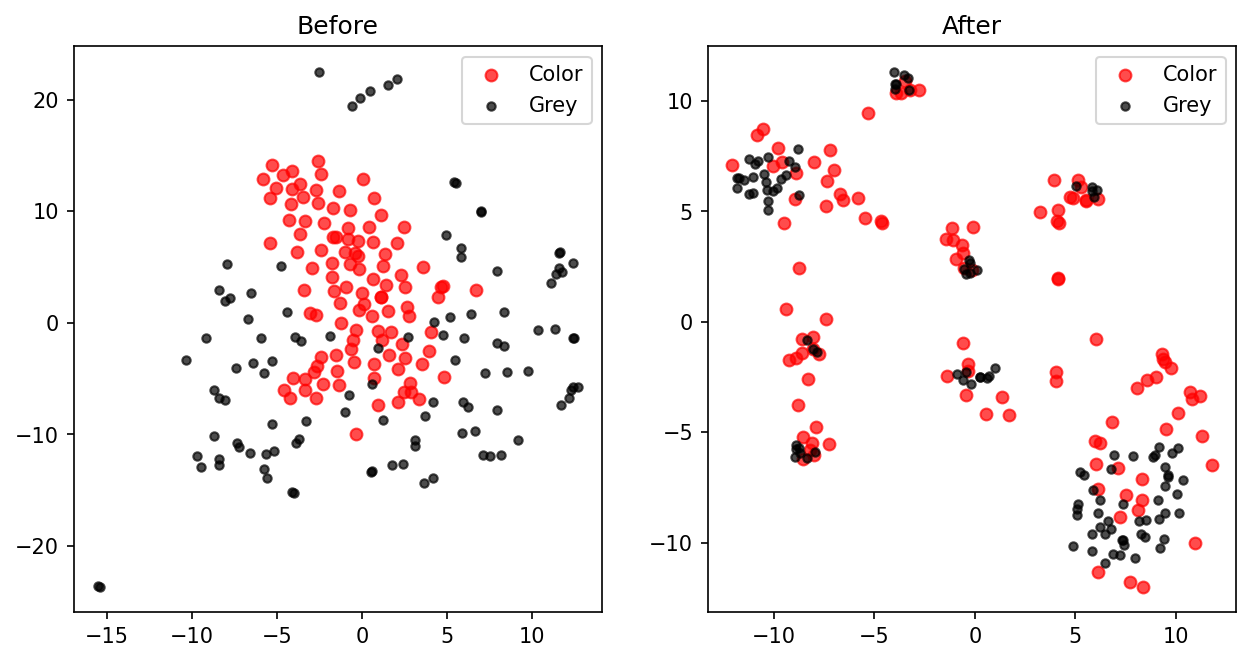

In [25]:
def plot_scatters(feat, colors = ['r', 'k'], labels=['', ''], sizes = [32, 16], title='', ax=None, figsize=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize if figsize is not None else None)
    nf = int(feat.shape[0] / 2)
    ax.scatter(feat[:nf, 0], feat[:nf, 1], s=sizes[0], c=colors[0], alpha=.7, label=labels[0]);
    ax.scatter(feat[nf:, 0], feat[nf:, 1], s=sizes[1], c=colors[1], alpha=.7, label=labels[1]);
    ax.legend(loc="upper right")
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_scatters(features_2d_orig, labels=['Color', 'Grey'], title='Before', ax=ax[0])
plot_scatters(features_2d, labels=['Color', 'Grey'], title='After', ax=ax[1])

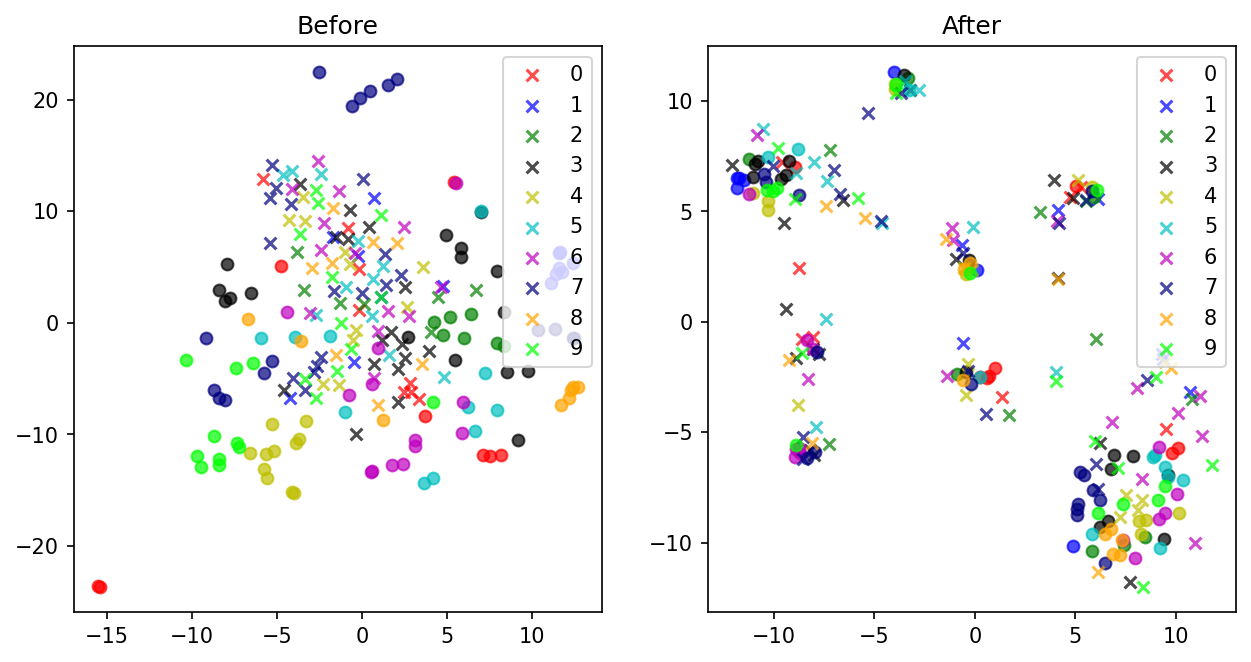

In [26]:
def plot_scatters_digits(feat, labels, colors=None, sizes = [32, 16], title='', ax=None, figsize=None, **kwargs):
    colors = ['r', 'b', 'g', 'k', 'y', 'c', 'm', 'navy', 'orange', 'lime'] if colors is None else colors
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize if figsize is not None else None)
    nf = int(feat.shape[0] / 2)
    sub1 = feat[:nf]
    sub1_l = np.array(labels[:nf])
    
    sub2 = feat[nf:]
    sub2_l = np.array(labels[nf:])
    for this_digit, color in zip(range(10), colors):
        if this_digit in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            ax.scatter(sub1[sub1_l == this_digit, 0], 
                       sub1[sub1_l == this_digit, 1], 
                       s=sizes[0], 
                       c=color,
                       marker='x',
                       alpha=.7, 
                       label=this_digit);

            ax.scatter(sub2[sub2_l == this_digit, 0], 
                   sub2[sub2_l == this_digit, 1], 
                   s=sizes[0],
#                    marker='x',
                   c=color, 
                   alpha=.7);

    ax.legend(loc="upper right")
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_scatters_digits(features_2d_orig, labels_tr_orig, title='Before', ax=ax[0])
plot_scatters_digits(features_2d, labels_tr, title='After', ax=ax[1])

In [27]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

def prep_img(x):
    img = np.flip(np.rot90(x.reshape(3, 28, 28).swapaxes(0, -1)), 0); 
    img += 1; img /= 2;
    return img

def prep_img_wb(x):
    img = np.flip(np.rot90(x.copy().reshape(3, 28, 28).swapaxes(0, -1)), 0); 
#     img += 1; img /= 2;
    return img * std_mnist + mean_mnist


def plot_scatters_imgs(feat, labels, imgs, title='', zoom=1, ax=None, figsize=None, mode='color', **kwargs):
    feat = feat.copy()
    imgs = imgs.copy()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize if figsize is not None else None)
    nf = int(feat.shape[0] / 2)
    
    feat[:, 0] -= np.min(feat[:, 0])
    feat[:, 0] /= np.max(feat[:, 0])
    feat[:, 1] -= np.min(feat[:, 1])
    feat[:, 1] /= np.max(feat[:, 1])
    
    sub1_f = feat[:nf]
    sub1_l = np.array(labels[:nf])
    sub1_i = imgs[:nf, ...]
    
    sub2_f = feat[nf:]
    sub2_l = np.array(labels[nf:])
    sub2_i = imgs[nf:, ...]
    for this_digit in range(10):
        selected = sub1_l == this_digit
        for isel, sel in enumerate(selected):
            if sel:
                imagebox = OffsetImage(prep_img(sub1_i[isel, ...]), zoom=zoom)
                ab = AnnotationBbox(imagebox, (sub1_f[isel, 0], sub1_f[isel, 1]), pad=0.0,
                                    bboxprops={'edgecolor': None,
                                                'linewidth': 0,
                                                'visible': True,
                                               'fill': None,
#                                                 'hatch': '*',
                                              })
                ax.add_artist(ab)
                
                if mode=='bw':
                    imagebox = OffsetImage(prep_img_wb(sub2_i[isel, ...]), zoom=zoom)
                else:
                    imagebox = OffsetImage(prep_img(sub2_i[isel, ...]), zoom=zoom)
                ab = AnnotationBbox(imagebox, (sub2_f[isel, 0], sub2_f[isel, 1]), pad=0.1,
                                    bboxprops={'edgecolor': None,
                                                'linewidth': 2,
                                                'linestyle': ':',
                                                'visible': True,
                                               'fill': None
                                              }
                                   )
                                   
                ax.add_artist(ab)
# #     ax.legend(loc="upper right")
#     ax.set_title(title)
    ax.axis('off')
    
# mpl.rcParams['figure.dpi']= 300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

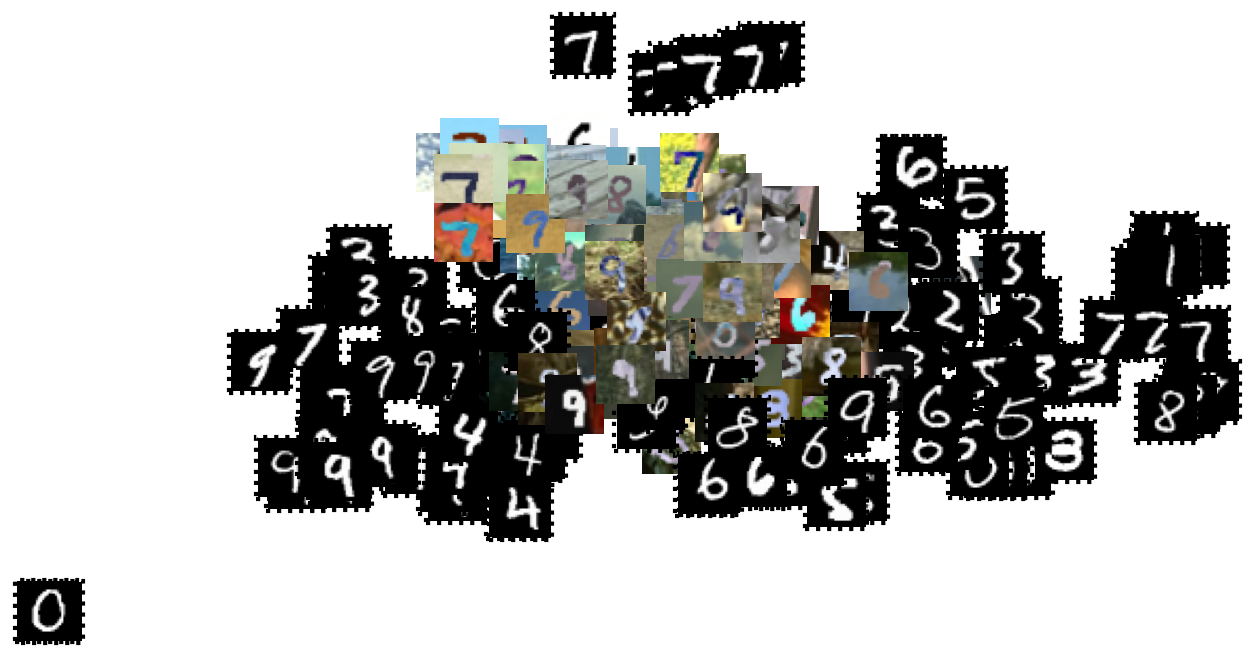

In [28]:
plot_scatters_imgs(features_2d_orig, labels_tr_orig, nums_tr_orig, zoom=1, figsize=(10, 5), mode='bw')

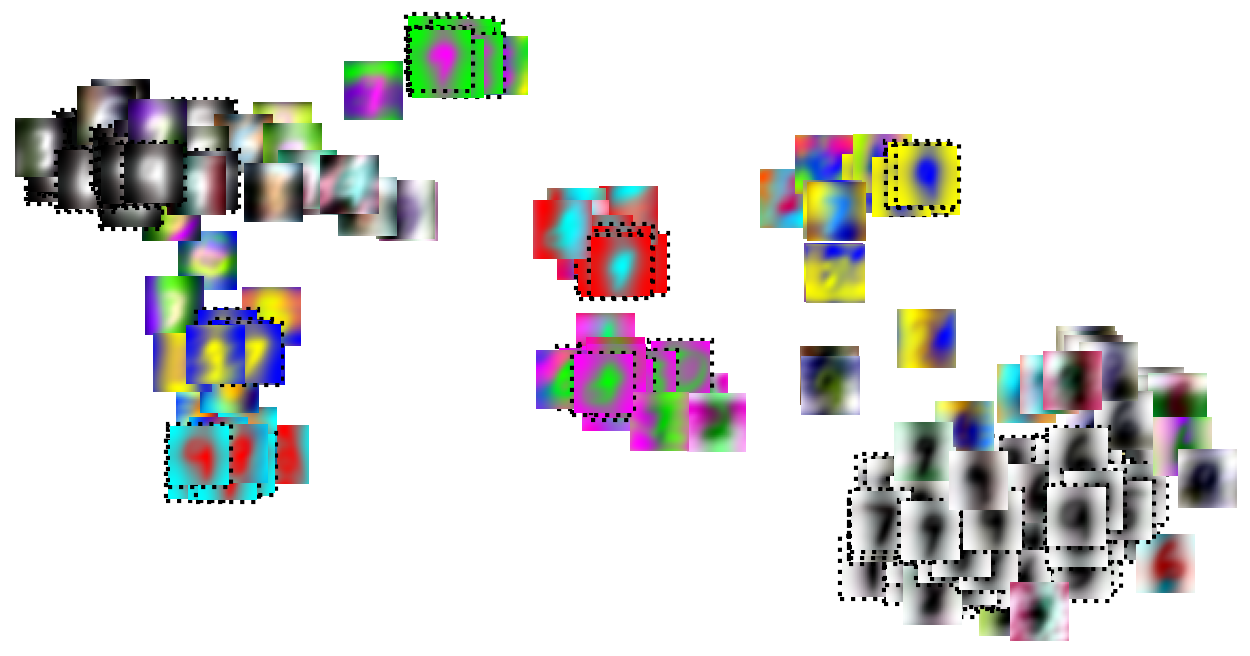

In [29]:
plot_scatters_imgs(features_2d, labels_tr, nums_tr, zoom=1, figsize=(10, 5))

# PCA

In [30]:
from sklearn.decomposition import PCA

print('Start PCA ...')
features_2d_pca = PCA(n_components=2).fit_transform(nums_tr)
features_2d_pca_orig = PCA(n_components=2).fit_transform(nums_tr_orig)
print(features_2d_pca.shape, features_2d_pca_orig.shape)

Start PCA ...
(216, 2) (216, 2)


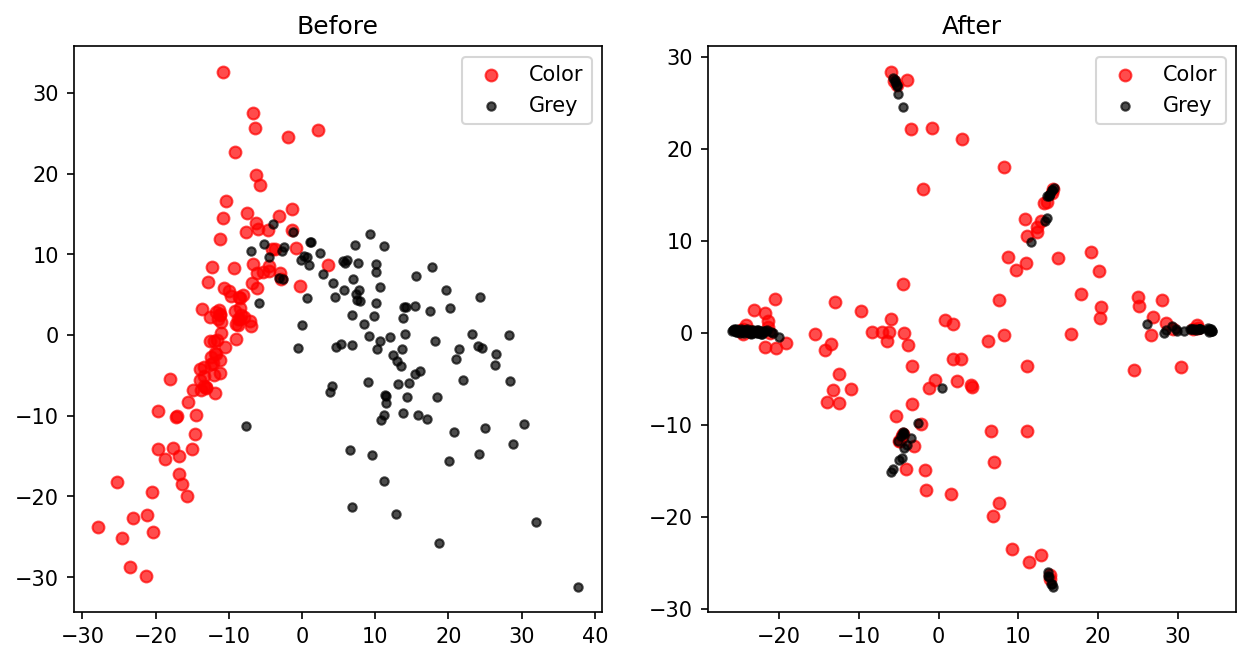

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_scatters(features_2d_pca_orig, labels=['Color', 'Grey'], title='Before', ax=ax[0])
plot_scatters(features_2d_pca, labels=['Color', 'Grey'], title='After', ax=ax[1])

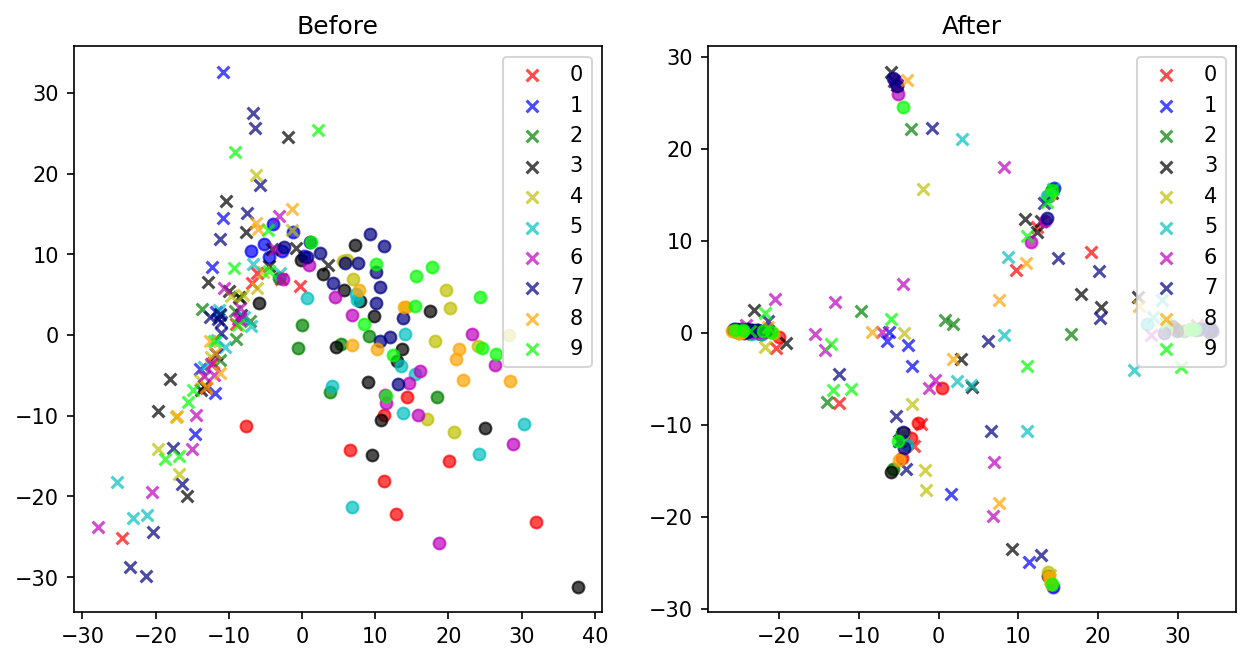

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_scatters_digits(features_2d_pca_orig, labels_tr_orig, title='Before', ax=ax[0])
plot_scatters_digits(features_2d_pca, labels_tr, title='After', ax=ax[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

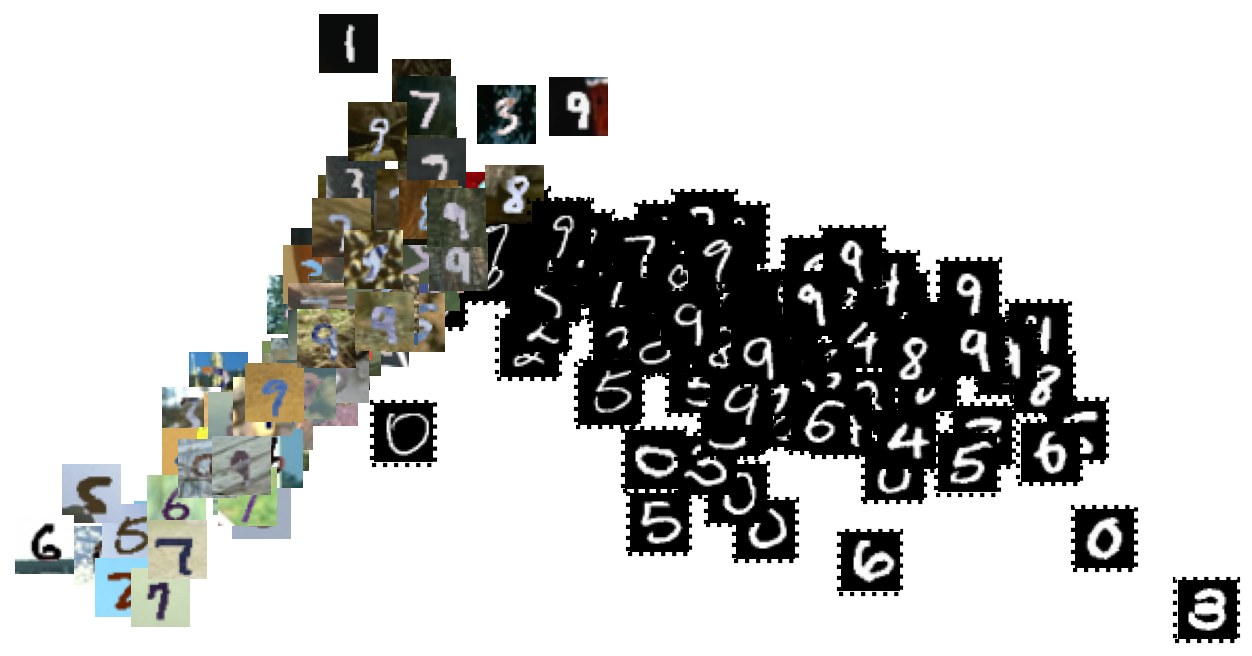

In [33]:
plot_scatters_imgs(features_2d_pca_orig, labels_tr_orig, nums_tr_orig, zoom=1, figsize=(10, 5), mode='bw')

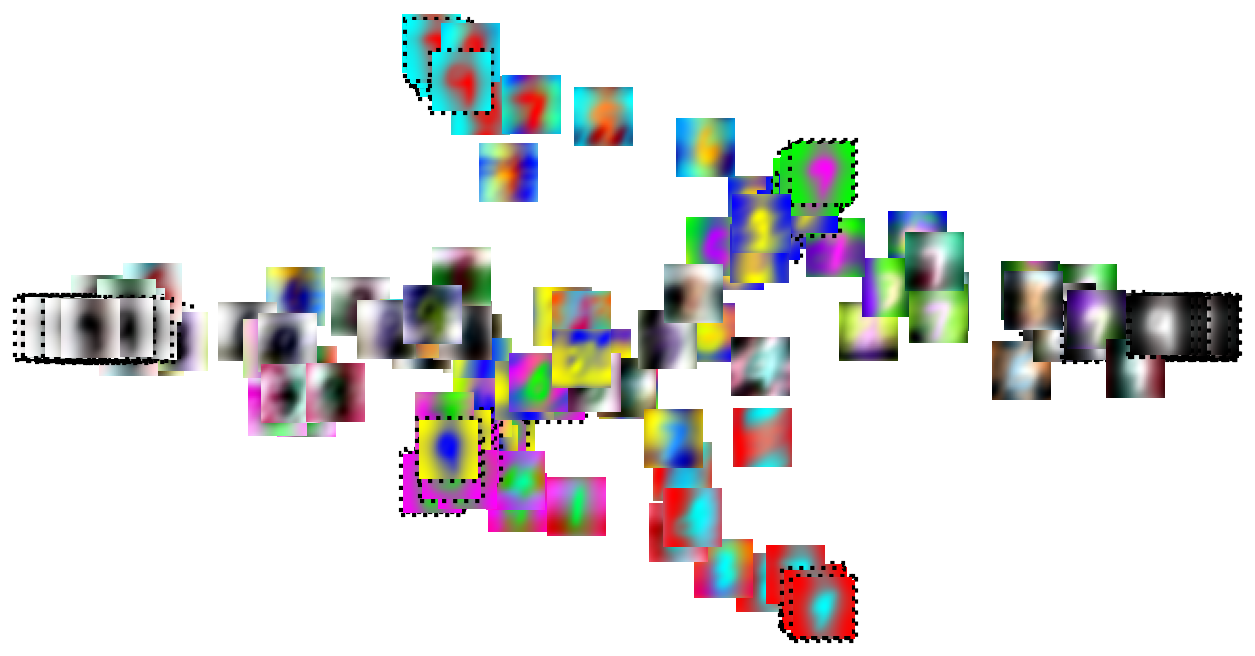

In [34]:
plot_scatters_imgs(features_2d_pca, labels_tr, nums_tr, zoom=1, figsize=(10, 5))